# Archive - Dont touch


In [ ]:
#  for band in relavant_band_real:
#             band = band.astype(np.float32)
#             median_filtered = cv2.medianBlur(band, ksize=kernel_size)
#             smfr_filtered = small_median_filter_residue(band, kernel_size=kernel_size) 
#             wiener_filtered = wiener_filter(band, kernel_size=kernel_size)
#             median_modified_wiener_filtered = median_modified_wiener_filter(band, kernel_size=kernel_size)

#             filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]

#             for filter_img in filters:
#                 filtered_clusters = kmeans(filter_img, n_clusters=3, display=False)
#                 largest_noise_clus = None
#                 max_noise = -1e32
#                 for clus in list(np.unique(filtered_clusters)):
#                     internal_mask = (filtered_clusters == clus).astype(np.int8)
#                     noise = (band - filter_img) * internal_mask
#                     noise_range = noise.max() - noise.min()

#                     if (noise_range > max_noise):
#                         largest_noise_clus = clus

#                 assert largest_noise_clus != None
#                 final_mask += (filtered_clusters == largest_noise_clus).astype(np.int8)

#         for band in relavant_band_imag:
#             band = band.astype(np.float32)
#             median_filtered = cv2.medianBlur(band, ksize=kernel_size)
#             smfr_filtered = small_median_filter_residue(band, kernel_size=kernel_size) 
#             wiener_filtered = wiener_filter(band, kernel_size=3)
#             median_modified_wiener_filtered = median_modified_wiener_filter(band, kernel_size=3)

#             filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]

#             for filter_img in filters:
#                 filtered_clusters = kmeans(filter_img, n_clusters=3, display=False)
#                 largest_noise_clus = None
#                 max_noise = -1e32
#                 for clus in list(np.unique(filtered_clusters)):
#                     internal_mask = (filtered_clusters == clus).astype(np.int8)
#                     noise = (band - filter_img) * internal_mask
#                     noise_range = noise.max() - noise.min()

#                     if (noise_range > max_noise):
#                         largest_noise_clus = clus

#                 assert largest_noise_clus != None
#                 final_mask += (filtered_clusters == largest_noise_clus).astype(np.int8)

# Load Libraries

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
from PIL import Image

# For semantic segmentation
import torch
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

# Uncomment to install PyWavelets
#!pip install PyWavelets
import pywt
import dtcwt

# Image Read

In [ ]:
def read_img(file_path):
    # Load the image
    img = plt.imread(file_path)

    # If Imag in BMP, combert it to jpeg
    if ".bmp" in file_path:
        # Convert and save as JPG
        img = img.convert("RGB").save("../temp.jpg", "JPEG")
        file_path = "../temp.jpg"
        img = plt.imread(file_path)


    # COnvert values to [0, 1] range.
    # .png files are fine, they are already read as float numbers [0,1]
    # .jpg are read as integer values [0,255]
    if ('jpg' in file_path) or ('jpeg' in file_path):
        img = img / 255

    return img

# Segmentation - KMeans and Semantic

In [149]:
def kmeans(img, n_clusters, display=False):
    data = img.reshape((-1, 1))
    H, W = img.shape

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    clusters = kmeans.fit_predict(data)
    clusters = clusters.reshape((H, W))

    if display:
        plt.imshow(clusters, cmap="Spectral")
        plt.title(f"Input Image Segmentation, n_clusters: {n_clusters}")
        plt.axis('off')
        plt.show()

    return clusters

In [178]:
# Semantic Segmentation of the image
def semantic_segmentation(img, n_clusters, display=False):

    # Load a pretrained DeepLabV3 model with ResNet-50 backbone
    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
    model.eval()  # Set the model to evaluation mode

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the preprocessing
    input_tensor = preprocess(img).float()
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    with torch.no_grad():
        output = model(input_batch)["out"][0]  # Shape: [21, H, W] for 21 classes   

    # Get the predicted class for each pixel
    segmentation = torch.argmax(output, dim=0).byte().cpu().numpy()

    if display:
        plt.imshow(segmentation)
        plt.title("Segmentation Mask")
        plt.axis("off")
        plt.show()

    return segmentation # THINK: Is it too many clusters?

# Band Processing

In [152]:
# Performs Log Normalization and z-tranforms and clips data [-1, 2] range
def normalize_coeffs(bands):
    reals = []
    imags = []
    for band in range(bands.shape[-1]):
        real_coeffs = bands[:, :, band].real
        imag_coeffs = bands[:, :, band].imag

        # Normalize
        # Log (1+x) transform
        real_coeffs = np.log1p(real_coeffs)
        imag_coeffs = np.log1p(imag_coeffs)

        # Z-Scaling
        real_coeffs = (real_coeffs - real_coeffs.mean()) / (real_coeffs.std() + 1e-8)
        imag_coeffs = (imag_coeffs - imag_coeffs.mean()) / (imag_coeffs.std() + 1e-8)

        # Clip - TODO: Findout why we need this?
        real_coeffs = np.clip(real_coeffs, -1, 2)
        imag_coeffs = np.clip(imag_coeffs, -1, 2)

        reals.append(real_coeffs)
        imags.append(imag_coeffs)

    return np.asarray(reals), np.asarray(imags)

In [153]:
def display_wavelet_coeffs(reals, imags, display=False):
    if display:
        plt.figure(figsize=(12, 4))
        for i, data in enumerate(zip(reals, imags)):
            real, imag = data

            plt.subplot(2, 6, i + 1)
            plt.imshow(real, cmap="Spectral")
            plt.title(f"Real, Band{i+1}")
            plt.axis('off')

            plt.subplot(2, 6, i + 7)
            plt.imshow(imag, cmap="Spectral")
            plt.title(f"Imag, Band{i+1}")
            plt.axis('off')

        plt.suptitle("Level 1, Real and Imaginary Bands 1-6")
        plt.show()

In [154]:
def get_patch_mean_variance(band, patch_size):
    H, W = band.shape
    patch_means = []
    for h in range(0, H, patch_size):
        for w in range(0, W, patch_size):
            patch = band[h:h+patch_size, w:w+patch_size]
            patch_means.append(np.mean(patch))

    var = np.var(patch_means)
    return var

In [155]:
def get_band_variance(mask, reals, imags, patch_size=16):
    real_var = []
    imag_var = []
    for real, imag in zip(reals, imags):
        # Real first
        band = mask * real
        real_var.append(get_patch_mean_variance(band, patch_size))
        
        # Imag
        band = mask * imag
        imag_var.append(get_patch_mean_variance(band, patch_size))

    return np.asarray(real_var), np.asarray(imag_var)

# Wavelets

In [267]:
# Return the coeffs of the DT-CWT transform
def wavelet_dtcwt(img):
    assert len(img.shape) == 2, "Not a grayscale image"

    # Initialize the DTCWT transform
    transform = dtcwt.Transform2d()

    # Perform the DTCWT on the image with only 1 level
    coeffs = transform.forward(img, nlevels=1)
    return coeffs.highpasses[0]


In [268]:
def wavelet_general(img, wavelet_type='haar'):

    if wavelet_type == 'dtcwt':
        return wavelet_dtcwt(img)

    LL, (LH, HL, HH) = pywt.dwt2(img, wavelet_type)
    print(LH.shape)
    H, W = LH.shape

    coeffs = np.zeros((H, W, 3))
    coeffs[:, :, 0] = LH
    coeffs[:, :, 1] = HL
    coeffs[:, :, 2] = HH

    return coeffs

# Noise Models


In [247]:
def noise_zero(img):
    return np.zeros_like(img)

# Filtering

In [248]:
def small_median_filter_residue(band, kernel_size):
    median_blur = cv2.medianBlur(band, ksize=kernel_size)
    first_diff = band - median_blur
    second_diff = cv2.medianBlur(band, ksize=kernel_size)
    return first_diff - second_diff

In [249]:
def wiener_filter(band, kernel_size=3, noise_variance=0.1):
    local_mean = cv2.blur(band, (kernel_size, kernel_size))
    local_variance = cv2.blur((band - local_mean) ** 2, (kernel_size, kernel_size))
    wiener_filtered = local_mean + (local_variance - noise_variance) / (local_variance + 1e-8) * (band - local_mean)
    return np.clip(wiener_filtered, 0, 1)  # Clipping to avoid overflow

In [250]:
def median_modified_wiener_filter(band, kernel_size=3, noise_variance=0.1):
    # Step 1: Apply median filter
    median_filtered = cv2.medianBlur(band, kernel_size)
    # Step 2: Apply Wiener filter to median-filtered band
    wiener_filtered = wiener_filter(median_filtered, kernel_size, noise_variance)
    return wiener_filtered

In [257]:
def get_mask_from_releavant_bands(bands, kernel_size):
    if len(bands) == 0:
        print("No bands avaialble. Adjust threshold maybe.")
        return 0

    final_mask = np.zeros_like(bands[0])
    for band in bands:
        band = band.astype(np.float32)
        median_filtered = cv2.medianBlur(band, ksize=kernel_size)
        smfr_filtered = small_median_filter_residue(band, kernel_size=kernel_size) 
        wiener_filtered = wiener_filter(band, kernel_size=kernel_size)
        median_modified_wiener_filtered = median_modified_wiener_filter(band, kernel_size=kernel_size)

        filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]

        for filter_img in filters:
            filtered_clusters = kmeans(filter_img, n_clusters=3, display=False)
            largest_noise_clus = None
            max_noise = -1e32
            for clus in list(np.unique(filtered_clusters)):
                internal_mask = (filtered_clusters == clus).astype(np.int8)
                noise = (band - filter_img) * internal_mask
                noise_range = noise.max() - noise.min()

                if (noise_range > max_noise):
                    largest_noise_clus = clus

            assert largest_noise_clus != None
            final_mask += (filtered_clusters == largest_noise_clus).astype(np.int8)

    return final_mask

# Wrapper Function

In [265]:
def detect_inpainting(file_path, wavelet_type, noise_func, patch_size=16, var_threshold=0.005, kernel_size=3):
    # Read Image
    img = read_img(file_path)
    
    # Display Input Image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()
    print("Image Shape ", img.shape)

    # Convert to grayscale
    gray_img = img.mean(axis=2)
    H, W = gray_img.shape

    clusters = semantic_segmentation(img, n_clusters=1, display=True)
    # TODO: Check if this is correct
    # We are W/2 and H/2 because the bands are of this size. But is this correct?
    clusters = clusters[::2, ::2]

    # Add Noise TODO: Check if this is the right place to add noise
    noise = noise_func(gray_img)
    gray_img += noise

    # DTCWT on grayscale image
    wavelet_coeffs = wavelet_general(gray_img, wavelet_type=wavelet_type) 
    ##########################
    # IMPORTANT: wavelet_coeffs has to of the shape [H/2, W/2, bands]
    ##########################
    # assert wavelet_coeffs.shape == ((H+1)//2, (W+1)//2, 6), f"wavelet_coeffs is of shape: {wavelet_coeffs.shape}, but it's supposed to be {((H+1)//2, (W+1)//2, 6)}"

    # Normalize
    real_coeffs, imag_coeffs = normalize_coeffs(wavelet_coeffs)

    # Display Normalized and Clipped Wavelet Coefficients
    display_wavelet_coeffs(real_coeffs, imag_coeffs, display= True)

    final_mask = np.zeros_like(real_coeffs[0]) # TODO: Put correct shape here

    for cluster in list(np.unique(clusters)):
        mask = (clusters == cluster).astype(np.int8)
        
        real_vars, imag_vars = get_band_variance(mask, real_coeffs, imag_coeffs, patch_size=patch_size)
        
        relavant_band_real = []
        relavant_band_imag = []

        print("Picked Bands:")
        for i in range(len(real_vars)):
            rvar, ivar = real_vars[i], imag_vars[i]

            if rvar >= var_threshold:
                relavant_band_real.append(mask * real_coeffs[i])
                print(f"Real {i+1}")

            if ivar >= var_threshold:
                relavant_band_imag.append(mask * imag_coeffs[i])
                print(f"Imag {i+1}")
                
        final_mask += get_mask_from_releavant_bands(relavant_band_real, kernel_size=kernel_size)
        final_mask += get_mask_from_releavant_bands(relavant_band_imag, kernel_size=kernel_size)
        
    plt.imshow(final_mask, cmap="gray")
    plt.axis('off')
    plt.title("Final Mask")
    plt.show()

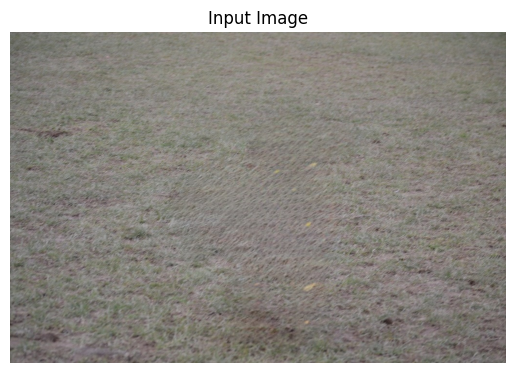

Image Shape  (683, 1024, 3)


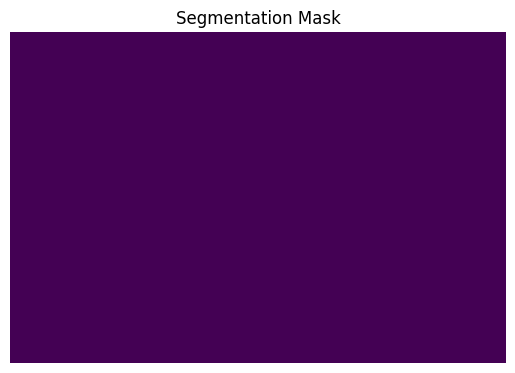

(342, 512)


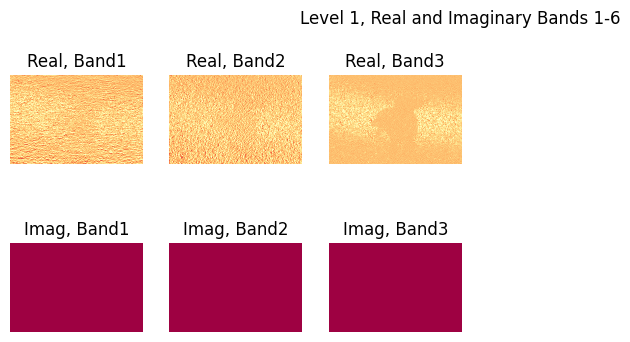

Picked Bands:
Real 3
No bands avaialble. Adjust threshold maybe.


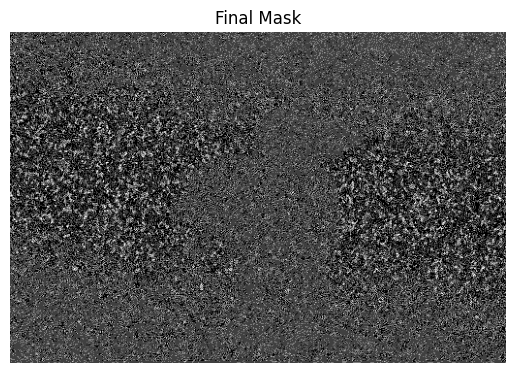

In [269]:
detect_inpainting(file_path="../img1.jpg", wavelet_type='haar', noise_func=noise_zero, kernel_size=3, patch_size=32, var_threshold=0.003)